In [1]:
from keras.datasets import mnist
from variational_autoencoder import VariationalAutoencoder
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

c:\users\vaibggup\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
print('Shapes :-')
print('x_train;', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

Shapes :-
x_train; (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)


In [4]:
x_train = x_train.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)

x_test = x_test.astype('float32') / 255.
x_test = np.expand_dims(x_test, -1)

In [5]:
print('Shapes :-')
print('x_train;', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

Shapes :-
x_train; (60000, 28, 28, 1)
y_train: (60000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)


Encoder and Decoder Definition for Variational Autoencoder

In [13]:
autoencoder = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
    , use_batch_norm = True
    , use_dropout = True)

In [14]:
autoencoder.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 28, 28, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 28, 28, 32)   0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
dropout_8 

In [15]:
autoencoder.compile(learning_rate=5e-4, r_loss_factor=1000)

In [16]:
run_folder = 'run'

In [24]:
autoencoder.train(x_train, batch_size=32, epochs=10, run_folder='run', initial_epoch=6)

Epoch 7/10
60000/60000 [==============================] - 1254s 21ms/step - loss: 52.9904 - vae_r_loss: 49.1602 - vae_kl_loss: 3.8302

Epoch 00007: saving model to run\weights/weights-007-52.99.h5
Epoch 8/10
60000/60000 [==============================] - 1228s 20ms/step - loss: 52.8140 - vae_r_loss: 48.9330 - vae_kl_loss: 3.8809

Epoch 00008: saving model to run\weights/weights-008-52.81.h5
Epoch 9/10
60000/60000 [==============================] - 1369s 23ms/step - loss: 52.6022 - vae_r_loss: 48.7013 - vae_kl_loss: 3.9009

Epoch 00009: saving model to run\weights/weights-009-52.60.h5
Epoch 10/10
60000/60000 [==============================] - 1415s 24ms/step - loss: 52.4899 - vae_r_loss: 48.5462 - vae_kl_loss: 3.9437

Epoch 00010: saving model to run\weights/weights-010-52.49.h5


In [25]:
num_pts_to_show = 5000
random_indexes = np.random.choice( range(len(x_test)), num_pts_to_show )

input_imgs = x_test[random_indexes]
labels = y_test[random_indexes]

pred_coords = autoencoder.encoder.predict(input_imgs)

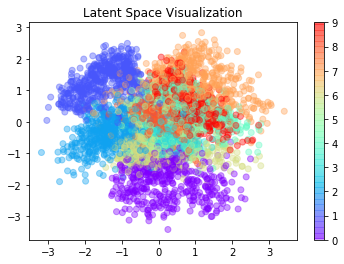

In [26]:
fig = plt.figure()

plt.title('Latent Space Visualization')
plt.scatter(pred_coords[:, 0], pred_coords[:, 1], c=labels, cmap='rainbow', alpha=0.4)
plt.colorbar()
plt.show()

plt.close(fig)

In [27]:
num_digits_to_show = 10

random_coords = np.random.normal(loc=0.0, scale=15, size=(num_digits_to_show, 2))
generated_digit_imgs = autoencoder.decoder.predict(random_coords)

generated_digit_imgs.shape

(10, 28, 28, 1)

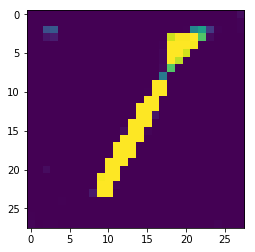

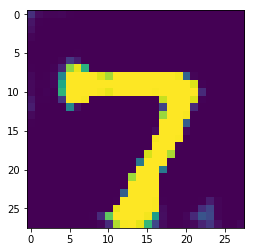

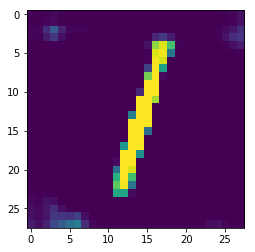

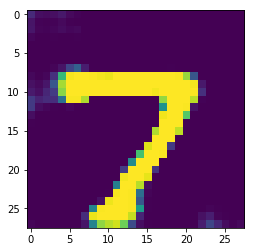

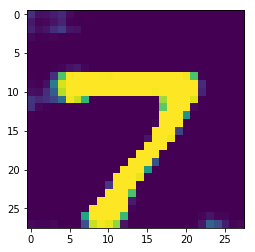

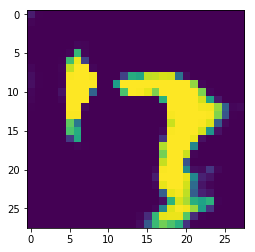

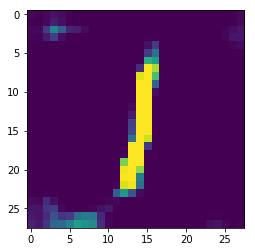

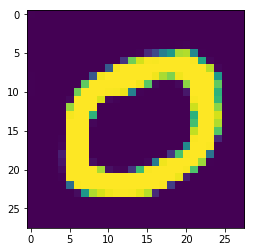

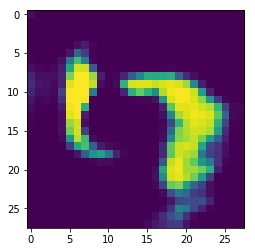

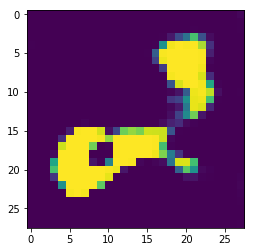

In [28]:
generated_digit_imgs = np.squeeze(generated_digit_imgs)

for digit in generated_digit_imgs:
    plt.imshow(digit)
    plt.show()